In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime

# Loading dataset

df = pd.read_csv("/content/university_mental_health_iot_dataset.csv")

df.head()


,timestamp,location_id,temperature_celsius,humidity_percent,air_quality_index,noise_level_db,lighting_lux,crowd_density,stress_level,sleep_hours,mood_score,mental_health_status
0,2024-05-01 08:00:00,104,24.328184,62.987529,67,54.429034,323.015836,45,23,7.22,2.3,0
1,2024-05-01 08:15:00,105,26.177300,52.482089,77,62.336451,412.211259,17,54,5.02,1.7,1
2,2024-05-01 08:30:00,103,25.443028,55.736424,120,51.967691,386.972786,35,39,4.96,2.9,0
3,2024-05-01 08:45:00,105,24.671652,71.484457,131,54.658851,339.056874,25,39,8.24,0.0,0
4,2024-05-01 09:00:00,105,21.628577,61.132704,81,60.623440,341.460697,36,18,6.61,3.0,0


In [2]:
df.info()

# renaming columns for clarity
df.columns = df.columns.str.lower().str.replace(" ", "_")

# converting timestamp column
df['timestamp'] = pd.to_datetime(df['timestamp'])

# missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             1000 non-null   object 
 1   location_id           1000 non-null   int64  
 2   temperature_celsius   1000 non-null   float64
 3   humidity_percent      1000 non-null   float64
 4   air_quality_index     1000 non-null   int64  
 5   noise_level_db        1000 non-null   float64
 6   lighting_lux          1000 non-null   float64
 7   crowd_density         1000 non-null   int64  
 8   stress_level          1000 non-null   int64  
 9   sleep_hours           1000 non-null   float64
 10  mood_score            1000 non-null   float64
 11  mental_health_status  1000 non-null   int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 93.9+ KB


,0
timestamp,0
location_id,0
temperature_celsius,0
humidity_percent,0
air_quality_index,0
noise_level_db,0
lighting_lux,0
crowd_density,0
stress_level,0
sleep_hours,0


In [26]:
# Simulating sending data one by one (like MQTT messages)
def simulate_iot_stream(data):
    for _, row in data.iterrows():
        payload = {
            "timestamp": row["timestamp"],
            "temperature": row["temperature_celsius"],
            "humidity": row["humidity_percent"],
            "air_quality_index": row["air_quality_index"],
            "lighting_lux": row["lighting_lux"]
        }
        yield payload

iot_stream = simulate_iot_stream(df)

In [27]:
# SQLite database
conn = sqlite3.connect("iot_sensor_data.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS sensor_data")

# Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS sensor_data (
    timestamp TEXT,
    temperature REAL,
    humidity REAL,
    air_quality_index REAL, -- Renamed from 'gas'
    lighting_lux REAL       -- Renamed from 'light'
)
""")

# inserting data
for message in iot_stream:
    cursor.execute("""
    INSERT INTO sensor_data (timestamp, temperature, humidity, air_quality_index, lighting_lux) VALUES (?, ?, ?, ?, ?)
    """, (
        message["timestamp"].strftime("%Y-%m-%d %H:%M:%S"),
        message["temperature"], # Assumes simulate_iot_stream in AANXIjpWFXsV is updated to use 'temperature' key from 'temperature_celsius'
        message["humidity"],
        message["air_quality_index"],
        message["lighting_lux"]
    ))

conn.commit()

In [28]:
query = "SELECT * FROM sensor_data"
db_df = pd.read_sql(query, conn)

db_df['timestamp'] = pd.to_datetime(db_df['timestamp'])
db_df.head()


,timestamp,temperature,humidity,air_quality_index,lighting_lux
0,2024-05-01 08:00:00,24.328184,62.987529,67.0,323.015836
1,2024-05-01 08:15:00,26.177300,52.482089,77.0,412.211259
2,2024-05-01 08:30:00,25.443028,55.736424,120.0,386.972786
3,2024-05-01 08:45:00,24.671652,71.484457,131.0,339.056874
4,2024-05-01 09:00:00,21.628577,61.132704,81.0,341.460697


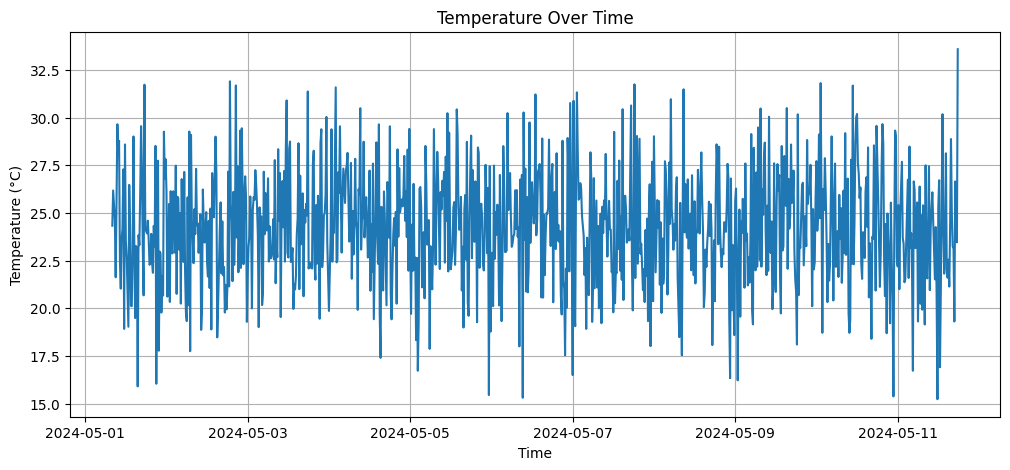

In [29]:
plt.figure(figsize=(12,5))
plt.plot(db_df['timestamp'], db_df['temperature'])
plt.title("Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()


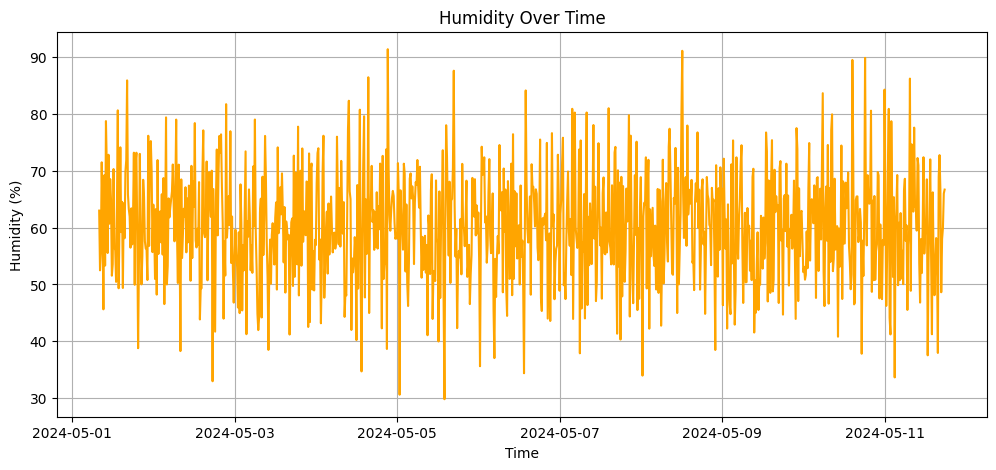

In [30]:
plt.figure(figsize=(12,5))
plt.plot(db_df['timestamp'], db_df['humidity'], color='orange')
plt.title("Humidity Over Time")
plt.xlabel("Time")
plt.ylabel("Humidity (%)")
plt.grid()
plt.show()


In [35]:
sns.set(style="whitegrid", palette="Set2")


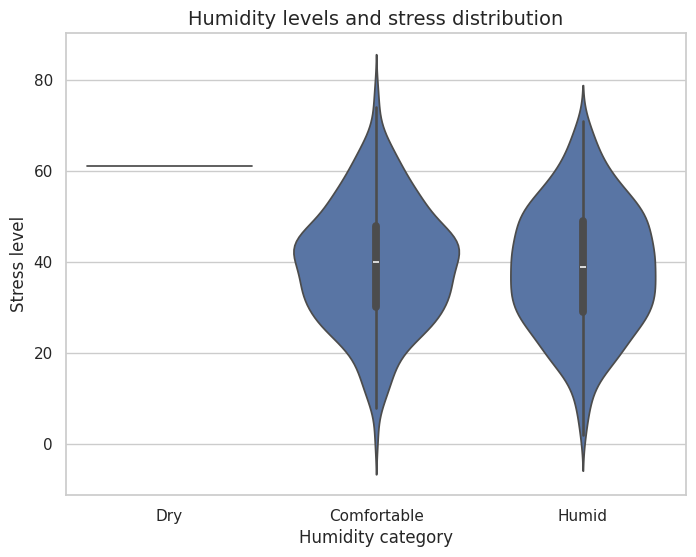

In [60]:
plt.figure(figsize=(8,6))
sns.violinplot(
    x=pd.cut(df['humidity_percent'], bins=[0,30,60,100],
             labels=['Dry','Comfortable','Humid']),
    y=df['stress_level']
)

plt.title("Humidity levels and stress distribution", fontsize=14)
plt.xlabel("Humidity category")
plt.ylabel("Stress level")
plt.show()


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")


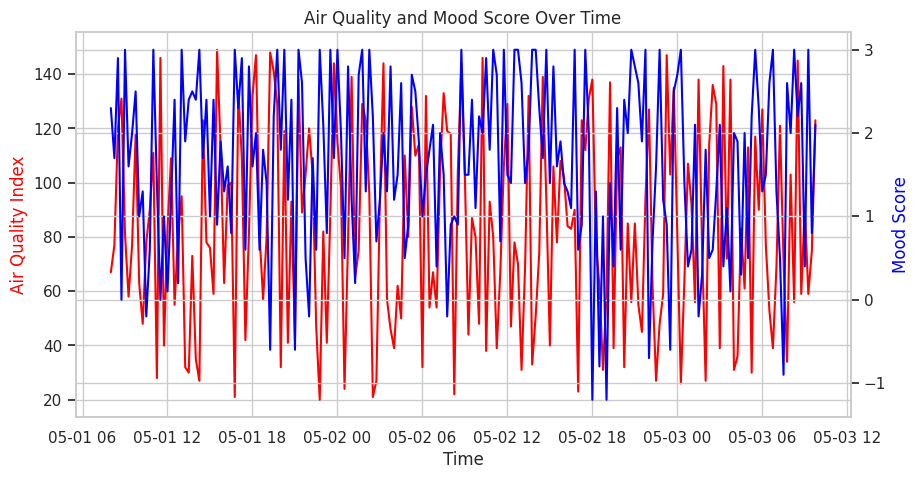

In [55]:
time_df = df.sort_values('timestamp').head(200)

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(time_df['timestamp'], time_df['air_quality_index'], color='red')
ax1.set_xlabel("Time")
ax1.set_ylabel("Air Quality Index", color='red')

ax2 = ax1.twinx()
ax2.plot(time_df['timestamp'], time_df['mood_score'], color='blue')
ax2.set_ylabel("Mood Score", color='blue')

plt.title("Air Quality and Mood Score Over Time")
plt.show()
